In [1]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import seaborn as sns
import pandas as pd
import os, glob, math, re, gzip, skbio, time
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings
from Bio import Entrez
warnings.filterwarnings('ignore')
Entrez.email = "ajaffe@stanford.edu"

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [3]:
import sys
sys.path.insert(0, '/home/users/ajaffe/notebooks/modules/')
import parse

In [4]:
rootdir = "/scratch/users/ajaffe/photoeco/"
deepeco = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir)

## create genome set

In [4]:
cmdir(rootdir + "genomes")
cmdir(rootdir + "genomes/prelim")

### input table

In [5]:
metadata = pd.read_csv(rootdir + "sag_metadata.csv", sep=",", 
                       header=None, dtype="str")[[2,0,1]].dropna(how="all").fillna("None")
metadata.columns = ["accession", "lineage", "sublineage"]
metadata.head()

,accession,lineage,sublineage
0,2626541501,AMZ I,A
1,2626541503,AMZ I,B
2,2626541504,AMZ I,A
3,2626541505,AMZ I,B
4,2626541506,AMZ I,B


### img

In [68]:
#to query img
#",".join([str(item) for item in metadata["accession"].to_list() if item.startswith("2")])

In [303]:
for item in glob.glob(rootdir + "genomes/img_data*/*/*.fna"):
    if ("genes" not in item) and ("intergenic" not in item):
        # rewrite sequence headers
        with open(rootdir + "genomes/prelim/" + os.path.basename(item), "w") as out:
            for record in sfp(open(item)):
                out.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))

### ncbi

In [ ]:
samns = []
nuc2sam = {}
nucs = []

for key, row in metadata[~metadata["accession"].str.startswith("2")].iterrows():
    
    accession_clean = row["accession"].replace(" ","")
    
    if "SAM" in accession_clean:
        samns.append(accession_clean)

    else: 

        try:
            nuccore = accession_clean.split(";")[0].split("/")[0]
            handle = Entrez.efetch(db="nuccore", id=nuccore, retmode="xml")
            soup = BeautifulSoup(handle, "html.parser")
            biosam = [item.string for item in soup.findAll("gbxref_id") if "SAM" in item.string]
            samns.append(biosam[0])
            nuc2sam[accession_clean] = biosam[0]

        except: 
            print("%s not found." %(accession_clean))
    
        time.sleep(1)

In [62]:
fixes = {"LVHL01000000": "SAMN04488532", "LVHM01000000": "SAMN04490358", "LVHN01000000": "SAMN04490360",
         "LVHP01000000": "SAMN04490362", "LVHQ01000000": "SAMN04490363", "LVHS01000000": "SAMN04490365",
            "NZ_JNAY0000000/739015208":"SAMN02769569", "LVHU01000000":"SAMN04490775","LVHV01000000":"SAMN04490776", "CP000551":"SAMN02603921",
            "JNAG00000000": "SAMN02769549", "JNBB00000000":"SAMN02769574", "NZ_JNAI00000000":"SAMN02769552",
            "NZ_JNAK00000000":"SAMN02769554", "ACDW00000000":"SAMN02436267", "NZ_JNAN00000000":"SAMN02769557",
             "NC_007577":"SAMN02598321", "NZ_JNAO00000000":"SAMN02769558", "NZ_JNAP00000000":"SAMN02769559",
             "CP000552":"SAMN02603924", "NZ_CP018345.1":"SAMN06061932", "NZ_JNAZ00000000":"SAMN02769570",
             "NZ_JNBD00000000":"SAMN02769571", "ALPH00000000":"SAMN02470451", "ALPI00000000":"SAMN02470447",
             "ALPB00000000":"SAMN02470450", "ALPC00000000":"SAMN02470511", "ALPL00000000":"SAMN02470473",
             "ALPE00000000":"SAMN02470468", "ALPF00000000":"SAMN02470472", "ALPG00000000":"SAMN02470491",
             "NC_007513":"SAMN02598312", "NC_009482":"SAMEA3138265", "AAUA01000001":"SAMN02436107",
             "AANP01000001":"SAMN02436139", "AANP01000001":"SAMN02436139", "AAOK01000001":"SAMN02436160"}
nuc2sam.update(fixes)

# to query ncbi
#" OR ".join(samns + list(fixes.values()))

Download assemblies and assembly structure dirs.

In [126]:
for item in glob.glob(rootdir + "genomes/ncbi*/*.fna"):
    with open(rootdir + "genomes/prelim/" + os.path.basename(item), "w") as out:
        for record in sfp(open(item)):
            out.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))

### amend metadata

In [63]:
sam2gen = {}

for item in glob.glob(rootdir + "genomes/genome*/*/*report.txt"):

    biosam, genbank = "",""
    for line in open(item).readlines():
        if line.startswith("# BioSample:"):
            biosam = line.split()[2]
        elif line.startswith("# GenBank assembly"):
            genbank = line.split()[4]
    
    sam2gen[biosam] = genbank

In [68]:
metadata["accession_clean"] = metadata["accession"].apply(lambda x: x.replace(" ", ""))

def match(row):
    
    file = ""
    acc = row["accession_clean"]
    
    try:
        if acc.startswith("2"):
            file = acc + ".fna"
        elif acc.startswith("SAM"):
            file = sam2gen[acc]
        else:
            try:
                sam = nuc2sam[acc]
                file = sam2gen[sam]
            except:
                acc = acc.split(";")[0].split("/")[0]
                sam = nuc2sam[acc]
                file = sam2gen[sam]
        
        gpath = glob.glob(rootdir + "genomes/prelim/" + file + "*")
        return os.path.basename(gpath[0]).replace(".fna", "")
    
    except: return "None"

metadata["filename"] = metadata.apply(match, axis=1)
metadata.query("filename=='None'")

,accession,lineage,sublineage,accession_clean,filename
128,SAMN07626394,unaffiliated,None,SAMN07626394,None
129,SAMN07626393,unaffiliated,None,SAMN07626393,None
132,SAMN02787045,unaffiliated,None,SAMN02787045,None
133,SAMN02787031,unaffiliated,None,SAMN02787031,None
134,SAMN02787032,unaffiliated,None,SAMN02787032,None
181,2681813566,LL IV,None,2681813566,None
184,2681813569,LL IV,None,2681813569,None
187,2681813571,LL II/III,None,2681813571,None


### deepeco

In [69]:
r_genomes = pd.read_csv(deepeco + "tables/redundant_genome_info.tsv", sep="\t")
nr_genomes = pd.read_csv(deepeco + "tables/nonredundant_genome_info.tsv", sep="\t")
nr_genomes[(nr_genomes["classification"].str.contains("Cyano")) & 
           (nr_genomes["scluster_rubisco_set"]=="I,II_II")]["secondary_cluster"].iloc[0]

'391_1'

In [70]:
deepinfo = defaultdict(list)

for key, row in r_genomes[r_genomes["secondary_cluster"]=="391_1"].iterrows():
    
    # write out the genomes
    with open(rootdir + "genomes/prelim/" + row["genome"] + ".fna", "w") as out:
        gpath = deepeco + "genomes/second_pass/" + row["genome"] + ".fa"
        for record in sfp(open(gpath)):
            out.write(">%s\n%s\n" %(record[0], record[1]))
            
    # add to metadata
    deepinfo["accession"].append(row["genome"])
    deepinfo["lineage"].append("unaffiliated")
    deepinfo["sublineage"].append("None")
    deepinfo["accession_clean"].append(row["genome"])
    deepinfo["filename"].append(os.path.basename(gpath).replace(".fa",""))

In [71]:
# also add other cyano mags found in odz samples and their relatives
abund = pd.read_csv(deepeco + "tables/table_s9.tsv", sep="\t").merge(nr_genomes[["genome","classification"]])
pro_samples = abund.query("genome=='GCA_030740955.1_ASM3074095v1_genomic'")["sample"].unique()
other_cyanos = abund[(abund["sample"].isin(pro_samples)) & (abund["classification"].str.contains("Cyano"))]["genome"].unique()
other_sgs = r_genomes[r_genomes["genome"].isin(other_cyanos)]["secondary_cluster"].unique()

for key, row in r_genomes[r_genomes["secondary_cluster"].isin(other_sgs)].iterrows():
    
    if row["genome"] not in r_genomes[r_genomes["secondary_cluster"]=="391_1"]["genome"].unique():
        
        # write out the genomes
        with open(rootdir + "genomes/prelim/" + row["genome"] + ".fna", "w") as out:
            gpath = deepeco + "genomes/second_pass/" + row["genome"] + ".fa"
            for record in sfp(open(gpath)):
                out.write(">%s\n%s\n" %(record[0], record[1]))

        # add to metadata
        deepinfo["accession"].append(row["genome"])
        deepinfo["lineage"].append("unaffiliated")
        deepinfo["sublineage"].append("None")
        deepinfo["accession_clean"].append(row["genome"])
        deepinfo["filename"].append(os.path.basename(gpath).replace(".fa",""))

In [82]:
metadata = pd.concat([metadata,pd.DataFrame(deepinfo)]).drop_duplicates()
metadata.head()

,accession,lineage,sublineage,accession_clean,filename
0,2626541501,AMZ I,A,2626541501,2626541501
1,2626541503,AMZ I,B,2626541503,2626541503
2,2626541504,AMZ I,A,2626541504,2626541504
3,2626541505,AMZ I,B,2626541505,2626541505
4,2626541506,AMZ I,B,2626541506,2626541506


### recover

In [130]:
# reload this to avoid re-running all of above
metadata_filtered = pd.read_csv(rootdir + "metadata_filtered.tsv", sep="\t")
metadata = metadata_filtered[["lineage", "sublineage", "accession_clean", "filename"]]
metadata = metadata[~metadata["filename"].str.contains("RR")]
metadata.head(5)

,lineage,sublineage,accession_clean,filename
0,AMZ I,A,2626541501,2626541501
1,AMZ I,B,2626541503,2626541503
2,AMZ I,A,2626541504,2626541504
3,AMZ I,B,2626541505,2626541505
4,AMZ I,B,2626541506,2626541506


In [131]:
recover_info = defaultdict(list)

for genome in glob.glob(rootdir + "curate/trimmed/*fna"):
    
    # write out the genomes
    name = os.path.basename(genome).replace(".fna","")
    with open(rootdir + "genomes/prelim/" + name + ".fna", "w") as out:
        for record in sfp(open(genome)):
            out.write(">%s\n%s\n" %(record[0], record[1]))

    # add to metadata
    recover_info["accession"].append(name)
    recover_info["lineage"].append("unaffiliated")
    recover_info["sublineage"].append("None")
    recover_info["accession_clean"].append(name)
    recover_info["filename"].append(name)
    
metadata = pd.concat([metadata,pd.DataFrame(recover_info)]).drop_duplicates()
metadata.tail()

,lineage,sublineage,accession_clean,filename,accession
52,unaffiliated,None,SRR11923214.100.6,SRR11923214.100.6,SRR11923214.100.6
53,unaffiliated,None,SRR11923211.100.10,SRR11923211.100.10,SRR11923211.100.10
54,unaffiliated,None,ERR598953.100.79,ERR598953.100.79,ERR598953.100.79
55,unaffiliated,None,SRR16028415.100.26,SRR16028415.100.26,SRR16028415.100.26
56,unaffiliated,None,SRR11787837.100.56,SRR11787837.100.56,SRR11787837.100.56


## evaluate genomes

### quality

In [108]:
cmdir(rootdir + "genomes/quality")

In [109]:
genomes = glob.glob(rootdir + "genomes/prelim/*")
n = math.ceil(len(genomes)/10)

for a, i in enumerate(range(0, len(genomes), n)):
    
    batchdir = rootdir + "genomes/quality/batch%s/" %(a)
    cmdir(batchdir)
    
    with open(rootdir + "genomes/quality/batch%d/batchfile.txt" %(a), "w") as out:
        for genome in genomes[i:i + n]:
            out.write(os.path.basename(genome).split(".fna")[0] + "\t" + genome + "\n")

In [110]:
with open(rootdir + "genomes/quality/run_checkm.sh", "w") as out:
    
    for batchdir in glob.glob(rootdir + "genomes/quality/batch*/"):

        call = "checkm lineage_wf -t 20 -x .fa --pplacer_threads 20 %s %s" %(batchdir + "batchfile.txt", batchdir)
        call2 = "checkm qa -t 20 -o 1 -f %s --tab_table %s %s" %(batchdir + "output_table.txt",
            batchdir + "lineage.ms", batchdir)
        cmd = sbatch("checkm", 20, "%s && %s" %(call, call2))
        out.write(cmd + "\n")

In [132]:
# read in all results
checkm_df = pd.concat([pd.read_csv(item, sep="\t") for item in 
    glob.glob(rootdir + "genomes/quality/batch*/output_table.txt")]).reset_index()
checkm_df = checkm_df[["Bin Id", "Completeness", "Contamination"]]
checkm_df.columns = ["user_genome", "checkm_completeness", "checkm_redundancy"]
metadata = metadata.merge(checkm_df, how="left", left_on="filename", right_on="user_genome").fillna("None")

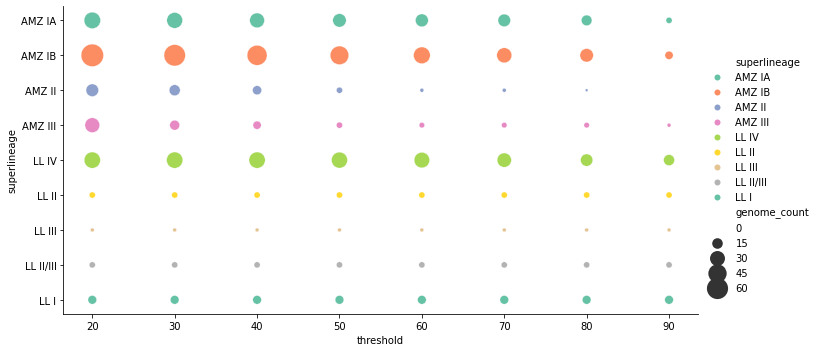

In [180]:
### visualize ecotype count w/ quality
#metadata["superlineage"] = metadata.apply(lambda x: x["lineage"] + x["sublineage"] if \
#                                          x["sublineage"]!='None' else x["lineage"], axis=1)
#metadata_filtered = metadata.query("filename!='None'").query("checkm_completeness!='None'")[["filename", "accession_clean", \
#                                                        "lineage", "sublineage", "superlineage",
#                                                        "checkm_completeness", "checkm_redundancy"]]
metadata_filtered = pd.read_csv(rootdir + "metadata_filtered.tsv", sep="\t")

thresh_info = defaultdict(list)

for threshold in range(20,100, 10):
    for superlineage in metadata_filtered["superlineage_curated"].unique():
        
        table = metadata_filtered[(metadata_filtered["superlineage_curated"]==superlineage) & \
                                  (metadata_filtered["checkm_completeness"]>=threshold)]
        
        thresh_info["threshold"].append(threshold)
        thresh_info["superlineage"].append(superlineage)
        thresh_info["genome_count"].append(len(table))

thresh_df = pd.DataFrame(thresh_info)
sns.relplot(x="threshold", y="superlineage", hue="superlineage", height=5, aspect=2, sizes=(0,500),
            size="genome_count", palette="Set2",
            data=thresh_df[thresh_df["superlineage"].str.contains("AMZ") | \
                           thresh_df["superlineage"].str.contains("LL")])
plt.show()

### similarity

In [134]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
from scipy import stats

In [135]:
cmdir(rootdir + "genomes/drep95")
cmdir(rootdir + "genomes/drep99")

In [136]:
# reformat quality information
drep_df = checkm_df.rename(columns={"checkm_completeness":"completeness","checkm_redundancy":"contamination"})
drep_df["genome"] = drep_df["user_genome"].apply(lambda x: x + ".fna")
drep_df[["genome", "completeness", "contamination"]].to_csv(rootdir + "genomes/drep95/genomeInformation.csv", sep=",", index=False)
drep_df[["genome", "completeness", "contamination"]].to_csv(rootdir + "genomes/drep99/genomeInformation.csv", sep=",", index=False)

In [137]:
for threshold in [0.95, 0.99]:
    
    thresh = str(int(threshold*100))
    call = "dRep dereplicate %s -pa 0.70 -sa %.2f -p 20 -comp 40 -con 25 -d -g %s --genomeInfo %s" %(rootdir + \
        "/genomes/drep" + thresh, threshold, rootdir + "/genomes/prelim/*fna",
        rootdir + "genomes/drep" + thresh + "/genomeInformation.csv")
    cmd = sbatch("drep", 20, call)
    print(cmd)

sbatch -J drep -p serc -t 1- -c 20 --mem 160G --wrap 'dRep dereplicate /scratch/users/ajaffe/photoeco//genomes/drep95 -pa 0.70 -sa 0.95 -p 20 -comp 40 -con 25 -d -g /scratch/users/ajaffe/photoeco//genomes/prelim/*fna --genomeInfo /scratch/users/ajaffe/photoeco/genomes/drep95/genomeInformation.csv'
sbatch -J drep -p serc -t 1- -c 20 --mem 160G --wrap 'dRep dereplicate /scratch/users/ajaffe/photoeco//genomes/drep99 -pa 0.70 -sa 0.99 -p 20 -comp 40 -con 25 -d -g /scratch/users/ajaffe/photoeco//genomes/prelim/*fna --genomeInfo /scratch/users/ajaffe/photoeco/genomes/drep99/genomeInformation.csv'


In [140]:
cluster_outputs = []

In [187]:
## visualize ANI matrix
ani = pd.read_csv(rootdir + "genomes/drep95/data_tables/Ndb.csv").query("primary_cluster==5")
anipiv = ani.pivot(index="reference", columns="querry", values="ani")

# cluster first
col_clustering = linkage(anipiv, method='average', metric="euclidean")
col_idx = dendrogram(col_clustering, no_plot=True)["ivl"]
cols = [anipiv.columns[int(i)] for i in col_idx]

# reshape
test = anipiv.reset_index()
test["order"] = test["reference"].apply(lambda x: cols.index(x))
test = test.sort_values("order")
test = test[cols]
test.index = cols

In [188]:
colors = []
palette = {"HL I": "blue", "HL II" :"blue", "HL III":"blue", "HL III/IV": "blue", "HL IV": "blue",
           "LL IV": "green", "LL I": "lightgreen", "LL II": "lightgreen", "LL III": "lightgreen", "LL II/III": "lightgreen",
           "5.1": "purple", "5.1A":"purple", "5.1B":"purple", "5.2":"purple", "5.3":"purple", 
           "AMZ IA" : "red", "AMZ IB": "orange", "AMZ II":"yellow", "AMZ III":"pink", "unaffiliated": "lightgrey"}

for item in cols:
    
    name = item.replace(".fna","")
    
    if name in metadata_filtered["filename"].unique():
        superlineage = metadata_filtered[metadata_filtered["filename"]==name]["superlineage_curated"].iloc[0]
        colors.append(palette[superlineage])
    else: colors.append("grey")

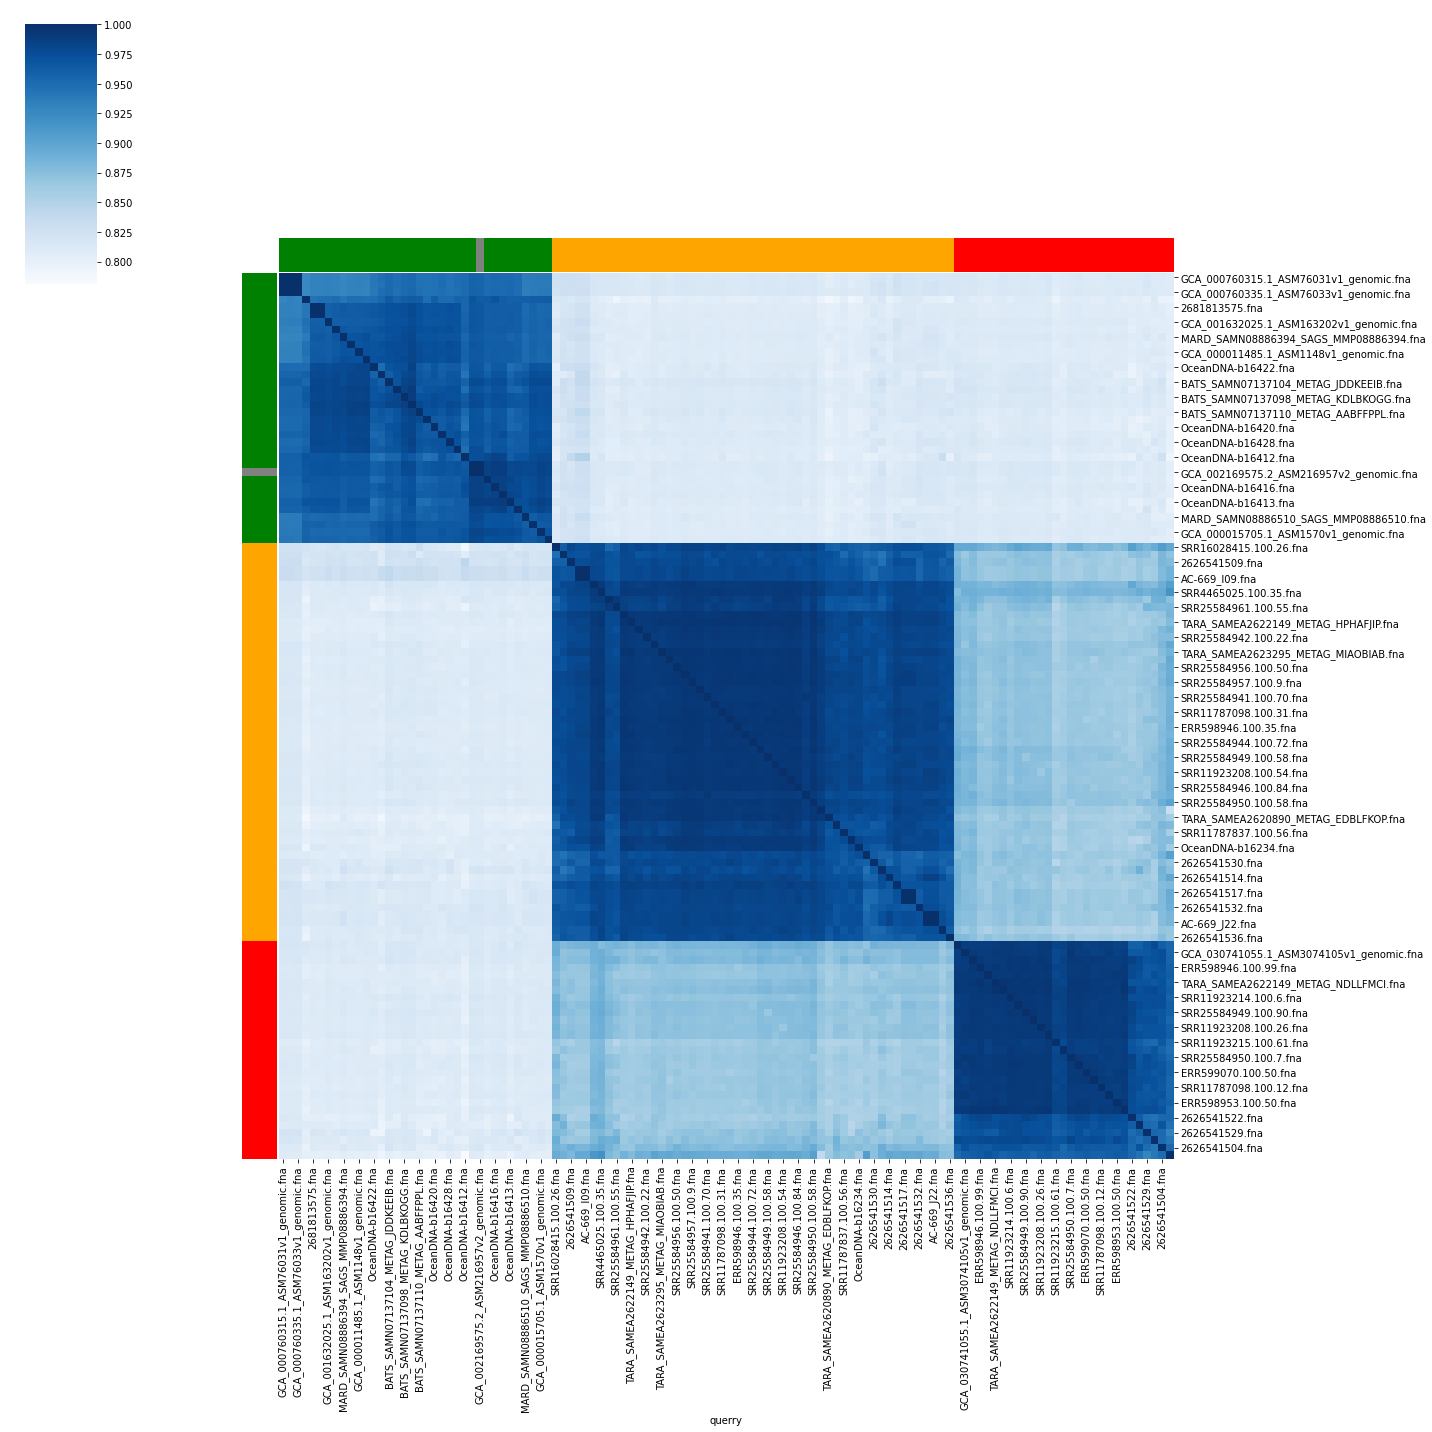

In [189]:
sns.clustermap(test, cmap="Blues", figsize=(20,20), 
               row_cluster=False, col_cluster=False, 
               row_colors=colors, col_colors=colors)
plt.show()

In [174]:
# assign clade names to unknown
assignments = fcluster(linkage(anipiv, method='average'), t=1, criterion="maxclust")
cluster_output = pd.DataFrame({'filename':[item.replace(".fna","") for item in anipiv.index] , 'cluster':assignments})
cluster_output = cluster_output.sort_values("cluster").merge(metadata_filtered[["filename", "superlineage"]], how="left").fillna("None")
cluster_agg = cluster_output.groupby("cluster", as_index=False).agg({"superlineage": lambda x: \
    stats.mode([item for item in x if item!='unaffiliated'])[0][0]}).rename(columns={"superlineage":"superlineage_revised"})
cluster_output = cluster_output.merge(cluster_agg)
cluster_outputs.append(cluster_output)

In [177]:
all_cluster_outputs = pd.concat(cluster_outputs)
metadata_filtered = metadata_filtered.merge(all_cluster_outputs[["filename", "superlineage_revised"]], how="left").fillna("None")
metadata_filtered["superlineage_curated"] = metadata_filtered.apply(lambda x: x["superlineage_revised"] if \
                                                                    x["superlineage_revised"]!='None' else x["superlineage"], axis=1)

## rubiscos

In [190]:
cmdir(rootdir + "genomes/filtered")
cmdir(rootdir + "rubisco")

### fix scaffolds

Modify this one genome to avoid collision with nearly identical verrsion with same scaffold names.

In [264]:
with open(rootdir + "genomes/prelim/AC-669_K20B.fna", "w") as out:
    for record in sfp (open(rootdir + "genomes/prelim/AC-669_K20.fna")):
        out.write(">%s\n%s\n" %(record[0] + "B", record[1]))

Then remove old version and rename this one.

In [268]:
scafdict = {}

for genome in glob.glob(rootdir + "genomes/filtered/*fna"):
    if "genes" not in genome:
        name = os.path.basename(genome).replace(".fna", "")
        for record in sfp(open(genome)):
            scafdict[record[0].split(" ")[0]] = name
        
scafdf = pd.DataFrame.from_dict(scafdict, orient="index").reset_index()
scafdf.columns = ["scaffold", "bin"]
scafdf.to_csv(rootdir + "scaf2bin.tsv", sep="\t", index=False)

scaf2bin = pd.read_csv(rootdir + "scaf2bin.tsv", sep="\t")
scaf2bin.head()

,scaffold,bin
0,JNAZ01000001.1,GCA_000760275.1_ASM76027v1_genomic
1,JNAZ01000002.1,GCA_000760275.1_ASM76027v1_genomic
2,JNAZ01000003.1,GCA_000760275.1_ASM76027v1_genomic
3,JNAZ01000004.1,GCA_000760275.1_ASM76027v1_genomic
4,JNAZ01000005.1,GCA_000760275.1_ASM76027v1_genomic


### extract + filter

In [265]:
prodigal = open(rootdir + "genomes/predict.sh", "w")

# subset genomes
for key, row in metadata_filtered.iterrows():
    
    if (row["checkm_completeness"]>=50) and (row["checkm_redundancy"]<=10):
        
        infile =rootdir + "genomes/prelim/" + row["filename"] + ".fna"
        outfile = rootdir + "genomes/filtered/" + row["filename"]
        with open(outfile + ".fna", "w") as out:
            
            for record in sfp(open(infile)):
                out.write(">%s\n%s\n" %(record[0], record[1]))
         
        if not os.path.isfile(outfile + ".genes.faa"):
        
            call = "prodigal -d %s -a %s -i %s -p single" %(outfile + ".genes.fna", \
                                                            outfile + ".genes.faa", outfile + ".fna")
            prodigal.write(call + " & ")
            
prodigal.close()

create sdev and run parallelized (may take a few tries)... then cat all faa together.

In [266]:
call = "hmmsearch --cpu 20 --domtblout %s \
            %s %s" %(rootdir + "rubisco/rubisco.results",
                     "/home/groups/dekas/ajaffe/hmms/rubisco/rubisco_all_profiles.hmm",
                     rootdir + "rubisco/all_genomes_protein.faa")
print(call)

hmmsearch --cpu 20 --domtblout /scratch/users/ajaffe/photoeco/rubisco/rubisco.results             /home/groups/dekas/ajaffe/hmms/rubisco/rubisco_all_profiles.hmm /scratch/users/ajaffe/photoeco/rubisco/all_genomes_protein.faa


In [269]:
hmm_results = parse.domtable(rootdir + "rubisco/rubisco.results")
# choose best hmm and filter by hmm cov
hmm_results = hmm_results.sort_values("score", ascending=False).drop_duplicates("gene").query("hmm_overall_cov>0.50")
hmm_results["scaffold"] = hmm_results["gene"].apply(scaffold)
# add in bin name
hmm_results = hmm_results.merge(scaf2bin, how="left", on="scaffold")
# modify hmm names
hmm_results = hmm_results.replace("I_all", "I").replace("IV_all", "IV").replace("II_II", "II")
hmm_results["hmm"].value_counts()

hmm
I     329
II     36
Name: count, dtype: int64

### similarity

In [272]:
import skbio

In [273]:
tmp = {record[0].split(" ")[0] : record[1] for record in
           sfp(open(rootdir + "rubisco/all_genomes_genes.fna"))}
hmm_results["sequence"] = hmm_results["gene"].map(tmp)
tmp = []

In [275]:
with open(rootdir + "rubisco/all_rubisco_genes.fna", "w") as out:
    for key, row in hmm_results.iterrows():
        out.write(">%s\n%s\n" %(row["gene"], row["sequence"]))
        
makedb = "makeblastdb -in %s -dbtype nucl -out %s" %(rootdir + "rubisco/all_rubisco_genes.fna",
                                           rootdir + "rubisco/all_rubisco_genes.db")
blast = "blastn -outfmt 6 -db %s -query %s -out %s" %(rootdir + "rubisco/all_rubisco_genes.db",
                                                                  rootdir + "rubisco/all_rubisco_genes.fna",
                                                                  rootdir + "rubisco/all_rubisco_genes.results")
print(blast)

blastn -outfmt 6 -db /scratch/users/ajaffe/photoeco/rubisco/all_rubisco_genes.db -query /scratch/users/ajaffe/photoeco/rubisco/all_rubisco_genes.fna -out /scratch/users/ajaffe/photoeco/rubisco/all_rubisco_genes.results


In [276]:
results = skbio.io.read(rootdir + "rubisco/all_rubisco_genes.results", format="blast+6", into=pd.DataFrame, default_columns=True)
resultspiv = results.pivot(index="qseqid", columns="sseqid", values="pident").fillna(0)

# cluster first
col_clustering = linkage(resultspiv, method='average', metric="euclidean")
col_idx = dendrogram(col_clustering, no_plot=True)["ivl"]
cols = [resultspiv.columns[int(i)] for i in col_idx]

# reshape
test = resultspiv.reset_index()
test["order"] = test["qseqid"].apply(lambda x: cols.index(x))
test = test.sort_values("order")
test = test[cols]
test.index = cols

In [277]:
ecotypes = []
forms = []

palette = {"HL I": "blue", "HL II" :"blue", "HL III":"blue", "HL III/IV": "blue", "HL IV": "blue",
           "LL IV": "green", "LL I": "lightgreen", "LL II": "lightgreen", "LL III": "lightgreen", "LL II/III": "lightgreen",
           "5.1": "purple", "5.1A":"purple", "5.1B":"purple", "5.2":"purple", "5.3":"purple", 
           "AMZ IA" : "red", "AMZ IB": "orange", "AMZ II":"yellow", "AMZ III":"pink", "unaffiliated": "lightgrey"}

for item in cols:
    if item in hmm_results["gene"].unique():
        genome = hmm_results[hmm_results["gene"]==item]["bin"].iloc[0]
        superlineage = metadata_filtered[metadata_filtered["filename"]==genome]["superlineage_curated"].iloc[0]
        ecotypes.append(palette[superlineage])
        form = hmm_results[hmm_results["gene"]==item]["hmm"].iloc[0]
        forms.append("black" if form == "II" else "darkgrey")
    else: colors.append("grey")

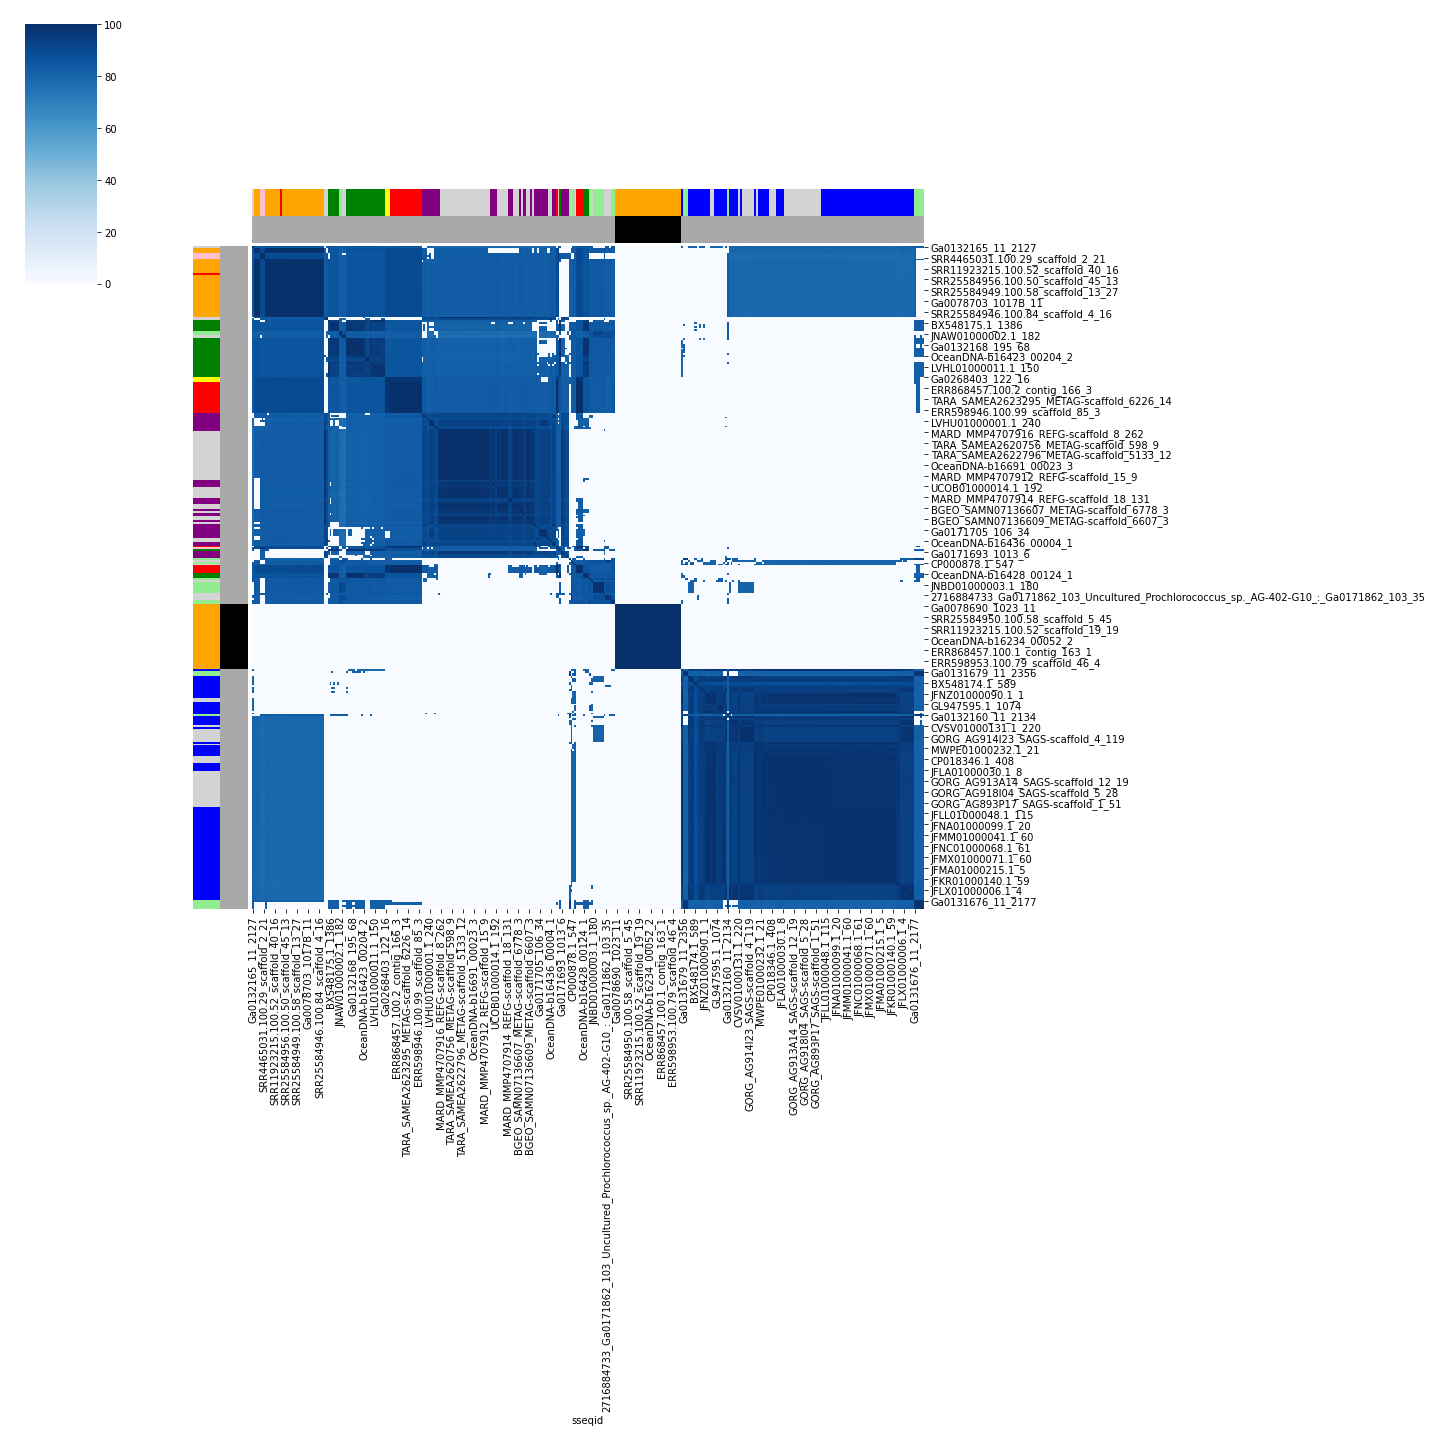

In [278]:
sns.clustermap(test, cmap="Blues", figsize=(20,20), 
               row_cluster=False, col_cluster=False, 
               row_colors=[ecotypes,forms], col_colors=[ecotypes, forms])
plt.show()

In [279]:
hmm_results = hmm_results.merge(metadata_filtered[["filename", "superlineage_curated"]],
                                how="left", left_on="bin", right_on="filename")
results = results.merge(hmm_results[["gene", "superlineage_curated"]], 
                        how="left", left_on="qseqid", right_on="gene").rename(columns={"superlineage_curated":"qlineage"})
results = results.merge(hmm_results[["gene", "hmm", "superlineage_curated"]],
                        how="left", left_on="sseqid", right_on="gene").rename(columns={"superlineage_curated":"slineage"})

In [280]:
siminfo = defaultdict(list)

for lineage in results["slineage"].unique():
    
    if lineage != 'unaffiliated':
        
        table = results[(results["qlineage"]=="AMZ IB") & 
                        (results["slineage"]==lineage) & (results["hmm"]=="I")]
        
        if len(table) > 0:
            
            siminfo["query"].append("AMZ IB")
            siminfo["subject"].append(lineage)
            avg = table["pident"].mean()
            siminfo["average_pident"].append(avg)

simdf = pd.DataFrame(siminfo)
simdf.sort_values("average_pident", ascending=False).head()

,query,subject,average_pident
0,AMZ IB,AMZ IB,99.796559
1,AMZ IB,AMZ IA,90.144620
2,AMZ IB,AMZ II,89.938951
3,AMZ IB,AMZ III,89.459176
4,AMZ IB,LL IV,86.095801


## export

In [239]:
# raw
metadata_filtered.to_csv(rootdir + "metadata_filtered.tsv", sep="\t", index=False)
# polished
base = metadata_filtered[["filename", "superlineage_curated", "checkm_completeness", "checkm_redundancy"]]
base = base[(base["checkm_completeness"]>=50) & (base["checkm_redundancy"]<=10)]
base.columns = ["genome_name", "lineage", "checkm_completeness", "checkm_redundancy"]

for drep in glob.glob(rootdir + "genomes/drep*/data_tables/Cdb.csv"):
    table = pd.read_csv(drep)
    table["genome_name"] = table["genome"].apply(lambda x: x.replace(".fna",""))
    table = table[["genome_name", "secondary_cluster"]].rename(columns={"secondary_cluster":"cluster" + drep.split("/")[-3].strip("drep")})
    base = base.merge(table, how="left").fillna("None")

base.to_csv(rootdir + "genome_table.tsv", sep="\t", index=False)

In [281]:
tmp = {record[0].split(" ")[0] : record[1] for record in
           sfp(open(rootdir + "rubisco/all_genomes_protein.faa"))}
hmm_results["protein_sequence"] = hmm_results["gene"].map(tmp)
tmp = []

hmm_results[["gene", "hmm", "scaffold", 
    "bin", "superlineage_curated", "protein_sequence"]].rename(columns={"bin":"genome_name",
    "superlineage_curated":"lineage"}).to_csv(rootdir + "rubisco_table.tsv", sep="\t", index=False)